In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate
from matplotlib import cm
from scipy import fft
from matplotlib.animation import FuncAnimation, PillowWriter 
import pandas as pd
from sklearn.linear_model import LinearRegression
import time
from scipy.interpolate import RegularGridInterpolator

In [38]:
# define parameters and functions:
alpha = .4
epsilon = .1 #.1 gives things that look like solitons
L_= 2
L = np.pi*L_
V = -1
D_ = 0.6 #very intereting with D=0.5 (which is the same as Ma=1/4) and D = 0.6
Ma_base=0.2
Omega = 1
delta = 0.5

In [39]:
N = 256
Nx = N
n = np.arange(N);
n[int(N/2)+1:] -= N

def RHS_time_dependent(t,eta):
    I = 1 + delta*np.sin(Omega*t)
    Ma = Ma_base*I
    D_ = 1-2*Ma
    eta_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(eta))
    eta_zzz = fft.ifft((n*2*np.pi/L*1j)**3*fft.fft(eta))
    deta_dt = -1/3*fft.ifft(2*n*np.pi/L*1j*fft.fft(eta**3*(1 + D_*eta_z + epsilon**2*eta_zzz))).real
    return deta_dt
def RHS_steady_current(t,eta):
    D_ = 1-2*Ma_base
    eta_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(eta))
    eta_zzz = fft.ifft((n*2*np.pi/L*1j)**3*fft.fft(eta))
    deta_dt = -1/3*fft.ifft(2*n*np.pi/L*1j*fft.fft(eta**3*(1 + D_*eta_z + epsilon**2*eta_zzz))).real
    return deta_dt

7


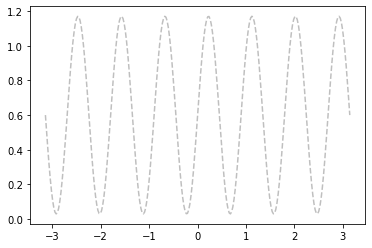

3.7699111843077517
Starting solve
(256, 300)  solved static
Time to solve 129.26353406906128 s
Starting solve
(256, 300)  solved static
Time to solve 149.18020486831665 s


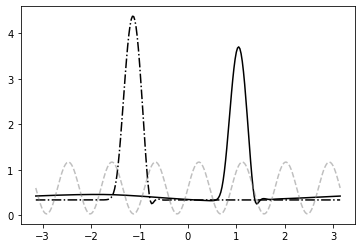

In [40]:
K = 1
T = 60
k = int(1/np.sqrt(2)/epsilon)
print(k)
z = np.linspace(-L/2, L/2, Nx)
t = np.linspace(0,T, 300)
t_span = (0,T)
u0 = (1 + np.sin(z*k)*0.95)*(1-alpha)*K
plt.plot(z,u0, '--', alpha = 0.5, color='grey', label='IC');plt.show()
print(np.trapz(u0, z))

print('Starting solve')
st = time.time()
result_static = scipy.integrate.solve_ivp(RHS_steady_current, t_span, u0, 'BDF', atol = 1e-2, t_eval = t)
u_static = result_static.y
print(np.shape(u_static), ' solved static')
et = time.time()
print(f'Time to solve {et-st} s')
print('Starting solve')
st = time.time()
result_time_dep = scipy.integrate.solve_ivp(RHS_time_dependent, t_span, u0, 'BDF', atol = 1e-2, t_eval = t)
u_time_dep = result_time_dep.y
print(np.shape(u_static), ' solved static')
et = time.time()
print(f'Time to solve {et-st} s')

Z,T = np.meshgrid(z,t)
plt.plot(z, u_static[:,-1], '-.',color='black', label='Travelling wave')
plt.plot(z, u_time_dep[:,-1], color='black', label='Travelling wave')
plt.plot(z,u0, '--', alpha = 0.5, color='grey', label='IC');plt.show()

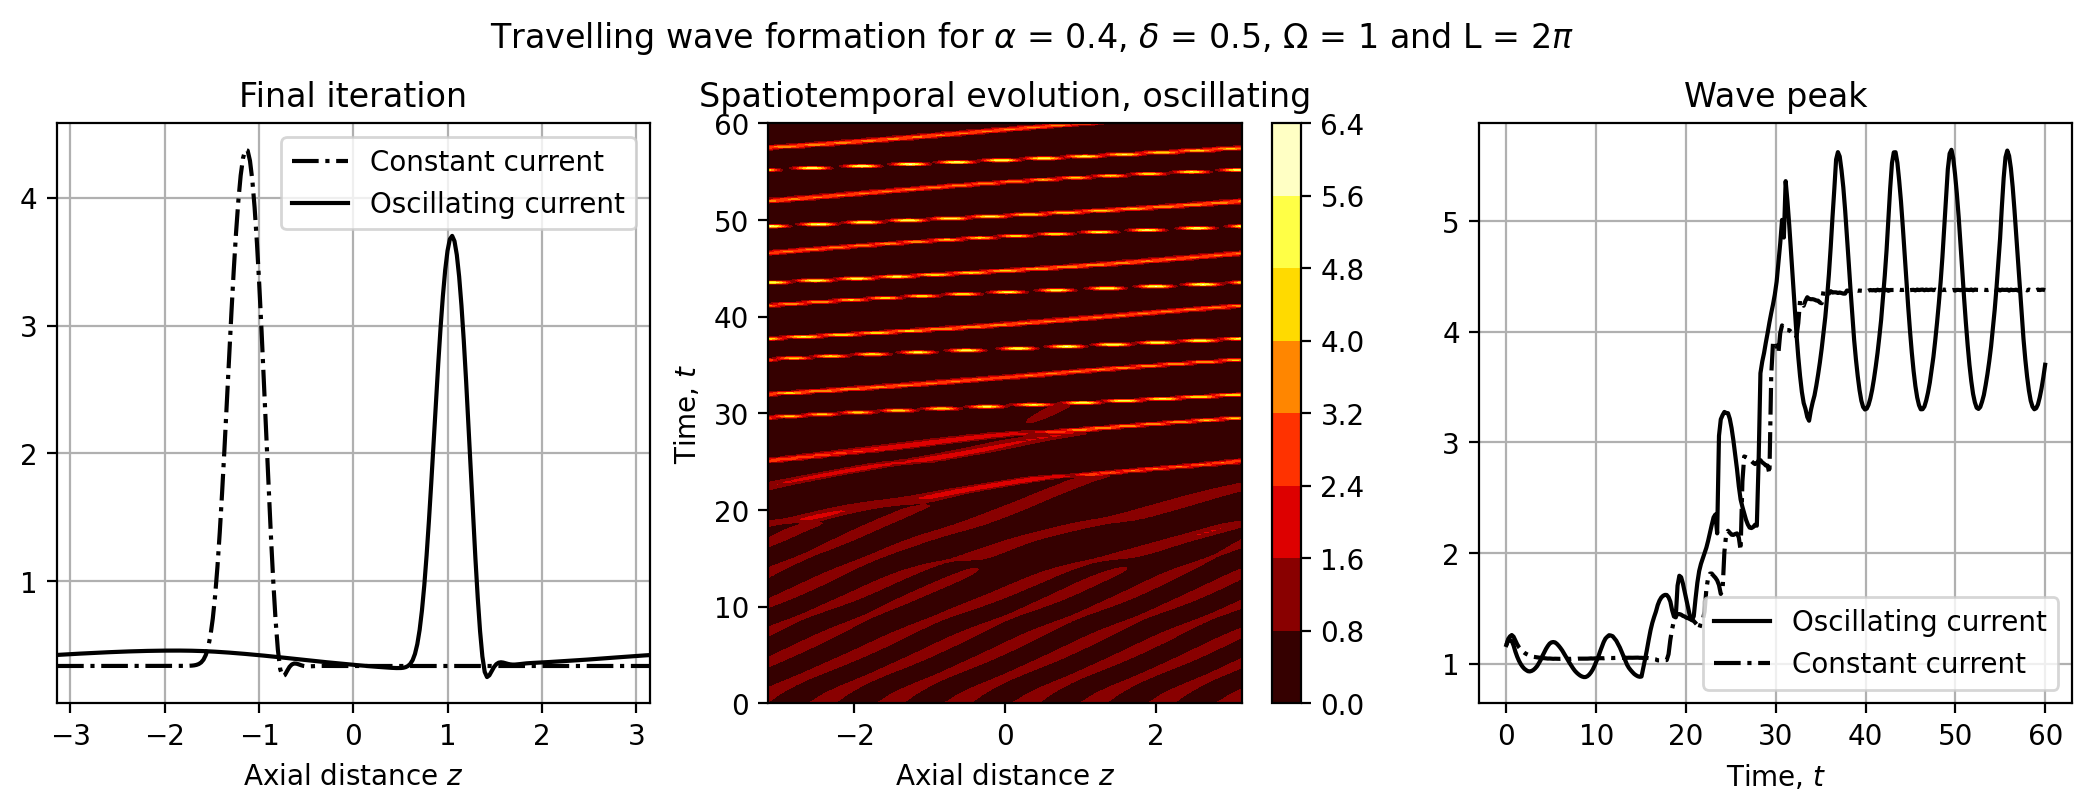

9.0
0.6
0.6010380708735382


In [42]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(13,4), dpi = 200)
#ax[0].contourf(Z,T,u_moving.T, cmap ='hot')
fig.suptitle(fr'Travelling wave formation for $\alpha$ = {alpha}, $\delta$ = {delta}, $\Omega$ = {Omega} and L = {L_}$\pi$')
ax[0].plot(z, u_static[:,-1], '-.',color='black', label='Constant current')
ax[0].plot(z, u_time_dep[:,-1],color='black', label='Oscillating current')
#ax[0].plot(z,u0, '--', alpha = 0.5, color='grey', label='I')
ax[0].set_xlabel(r'Axial distance $z$')
ax[0].set_title('Final iteration')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim([-L/2, L/2])
c2 = ax[1].contourf(Z,T,u_time_dep.T, cmap ='hot')
ax[1].set_title('Spatiotemporal evolution, oscillating')
ax[1].set_xlabel(r'Axial distance $z$')
ax[1].set_ylabel(r'Time, $t$')
fig.colorbar(c2, ax=ax[1])
#ax[2].plot(np.trapz(u_static, z, axis=0))

ax[2].plot(t,np.max(u_time_dep, axis=0), label='Oscillating current', color='black')
ax[2].plot(t,np.max(u_static, axis=0), '-.',label='Constant current', color='black')
ax[2].grid(True)
ax[2].set_title('Wave peak')
ax[2].set_xlabel(r'Time, $t$')
ax[2].legend()
#ax[2].plot(np.trapz(u_static**2, z, axis=0))
#plt.colorbar()
#plt.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig(f'figures/osc_current_alpha_{alpha}_delta_{delta}_Omega_{Omega}.pdf')
plt.show()
print((1-alpha)*15)
print(np.trapz(u0,z)/L)
print(np.trapz(u_static[:,-1],z)/L)

MovieWriter imagemagick unavailable; using Pillow instead.


FileNotFoundError: [Errno 2] No such file or directory: 'movies/travelling_wave_formation.gif'

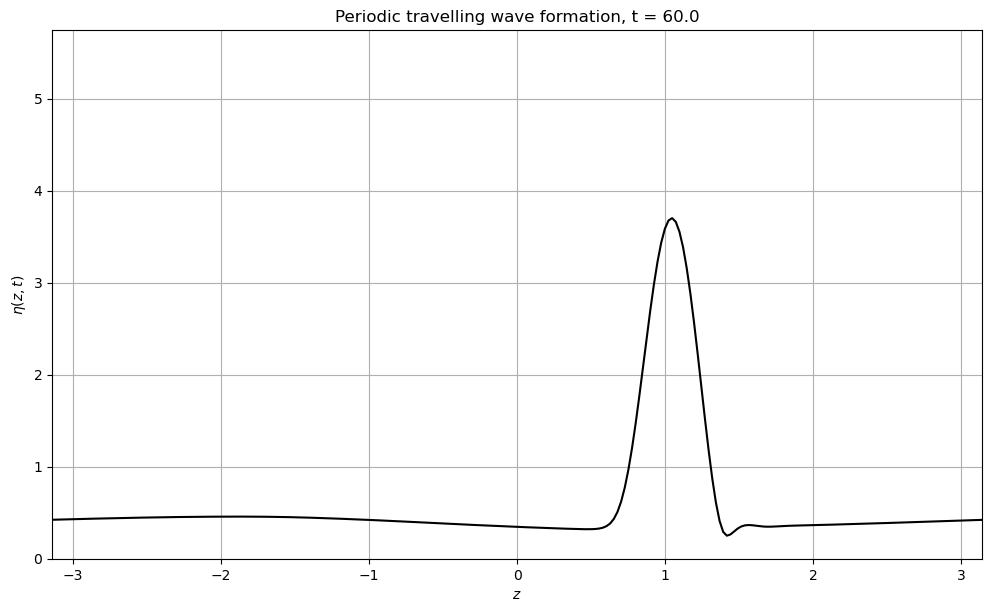

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12,7), dpi=100)

def init():
    ax.plot(z,  u_time_dep[:,0])
def update(i):
    ax.cla()
    time = t[i]
    #print(time)
    ax.plot(z, u_time_dep[:,i],color = 'black')
    ax.set_title(f'Periodic travelling wave formation, t = {round(time,2)}')
    ax.set_ylim([0,np.max(u_time_dep)+0.1])
    ax.set_xlim([np.min(z), np.max(z)])
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\eta(z,t)$')
    ax.grid()
    fig.set_facecolor('xkcd:white')
ani = FuncAnimation(fig,  update, range(0,300), init_func=init, repeat=False, interval=1)
#writer = PillowWriter(fps = 10)
ani.save(f'movies/travelling_wave_formation.gif', writer='imagemagick', fps=30)